## importing the CSV file 

In [1]:
import pandas as pd

# Load your dataset
df = pd.read_csv("data.csv")

# See the first few rows
print(df.head())


                                                 url property_id  \
0  https://immovlan.be/en/detail/apartment/for-sa...    rbu58257   
1  https://immovlan.be/en/detail/apartment/for-sa...    rbu36061   
2  https://immovlan.be/en/detail/apartment/for-sa...    vbd48093   
3  https://immovlan.be/en/detail/apartment/for-sa...    rbu58259   
4  https://immovlan.be/en/detail/apartment/for-sa...    rbu36063   

  property_type          locality_name  postal_code  build_year   state  \
0     Apartment               Brussels       1000.0      2004.0  Normal   
1     Apartment               Turnhout       2300.0      2024.0     New   
2     Apartment  Berchem-Sainte-Agathe       1082.0      1939.0  Normal   
3     Apartment               Brussels       1000.0      2013.0  Normal   
4     Apartment               Turnhout       2300.0      2024.0     New   

   living_area  furnished  number_rooms  equipped_kitchen  terrace  facades  \
0         35.0        1.0           1.0               NaN    

## Remove duplicates

In [2]:
# Count duplicates before removing
print("Duplicates before:", df.duplicated().sum())

# Remove them
df = df.drop_duplicates()

print("Duplicates after:", df.duplicated().sum())


Duplicates before: 0
Duplicates after: 0


## Remove Blank Spaces in Text Columns

In [39]:
# Go through all text (object) columns and strip spaces
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].str.strip()
display(df.head())    


,url,property_id,property_type,locality_name,postal_code,build_year,state,living_area,number_rooms,terrace,facades,garden,swimming_pool,price
0,https://immovlan.be/en/detail/apartment/for-sa...,rbu58257,Apartment,Brussels,1000.0,2004.0,Normal,35.0,1.0,1.0,2.0,0,0,225000.0
1,https://immovlan.be/en/detail/apartment/for-sa...,rbu36061,Apartment,Turnhout,2300.0,2024.0,New,59.0,1.0,1.0,3.0,0,0,197000.0
2,https://immovlan.be/en/detail/apartment/for-sa...,vbd48093,Apartment,Berchem-Sainte-Agathe,1082.0,1939.0,Normal,65.0,2.0,1.0,2.0,0,0,169000.0
3,https://immovlan.be/en/detail/apartment/for-sa...,rbu58259,Apartment,Brussels,1000.0,2013.0,Normal,57.0,1.0,1.0,2.0,0,0,220000.0
4,https://immovlan.be/en/detail/apartment/for-sa...,rbu36063,Apartment,Turnhout,2300.0,2024.0,New,66.0,1.0,1.0,3.0,0,0,225000.0


## Handle Empty or Missing Values

In [46]:
import numpy as np

# Replace blank strings ("") with None
df = df.replace(r'^\s*$', np.nan, regex=True)

# Check how many missing values in each column
print(df.isna().sum())
df[df.isna().any(axis=1)]



url                 1
property_id         0
property_type     809
locality_name     190
postal_code       190
build_year       2996
state            2465
living_area      1203
number_rooms      935
terrace          1077
facades          2490
garden              0
swimming_pool       0
price             791
dtype: int64


,url,property_id,property_type,locality_name,postal_code,build_year,state,living_area,number_rooms,terrace,facades,garden,swimming_pool,price
7,https://immovlan.be/en/detail/apartment/for-sa...,rbu60048,Apartment,Brussels,1000.0,NaN,Normal,37.0,1.0,0.0,NaN,0,0,219000.0
13,https://immovlan.be/en/detail/apartment/for-sa...,vbd42948,Apartment,Ganshoren,1083.0,NaN,NaN,76.0,2.0,1.0,1.0,0,0,215000.0
18,https://immovlan.be/en/detail/apartment/for-sa...,rwc41104,Apartment,Brussels,1000.0,2015.0,Normal,76.0,1.0,NaN,NaN,0,0,225000.0
19,https://immovlan.be/en/detail/apartment/for-sa...,vbd45665,Apartment,Ganshoren,1083.0,1965.0,NaN,88.0,2.0,1.0,NaN,0,0,254000.0
26,https://immovlan.be/en/detail/apartment/for-sa...,vbd47951,Apartment,Ganshoren,1083.0,NaN,NaN,94.0,2.0,1.0,NaN,0,0,260000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7217,https://immovlan.be/en/projectdetail/24794-009...,24794-00919214_om_9933,NaN,Willebroek,2830.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
7218,https://immovlan.be/en/projectdetail/25923-723...,25923-7235431,NaN,Nevele,9850.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
7219,https://immovlan.be/en/projectdetail/vi0002198,vi0002198,NaN,Visé,4600.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
7220,https://immovlan.be/en/projectdetail/2480528-r...,2480528-rmg01404929_om_246884,NaN,Antwerp,2000.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN


## Fix Wrongly Encoded Values (e.g., text in numeric columns)

In [57]:
# Function to clean numeric columns
def to_number(s):
    return pd.to_numeric(
        s.astype(str).str.replace(r"[^\d\.\-]", "", regex=True),
        errors="coerce"
    )

# Apply to common numeric columns
numeric_cols = ["postal_code", "build_year", "living_area", "furnished","number_rooms", "facades", "garden_area","price"]

for col in numeric_cols:
    if col in df.columns:
        df[col] = to_number(df[col])
    
    # normalization for ALL boolean-like columns

    bool_cols = ["terrace","garden","swimming_pool"]

    for col in bool_cols:
        if col in df.columns:
           df[col] = normalize_bool(df[col]).fillna(0).astype(int)

    



        
print(df.info())         # check data types
print(df.isna().sum())   # missing values per column



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7222 entries, 0 to 7221
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   url            7221 non-null   object 
 1   property_id    7222 non-null   object 
 2   property_type  6413 non-null   object 
 3   locality_name  7032 non-null   object 
 4   postal_code    7032 non-null   float64
 5   build_year     4226 non-null   float64
 6   state          4757 non-null   object 
 7   living_area    6019 non-null   float64
 8   number_rooms   6287 non-null   float64
 9   terrace        7222 non-null   int64  
 10  facades        4732 non-null   float64
 11  garden         7222 non-null   int64  
 12  swimming_pool  7222 non-null   int64  
 13  price          6431 non-null   float64
dtypes: float64(6), int64(3), object(5)
memory usage: 790.0+ KB
None
url                 1
property_id         0
property_type     809
locality_name     190
postal_code       190
build_year

## remove columuns (furnished,equipped_kitchen and garden area)

In [66]:
#df = df.drop(['furnished', 'equipped_kitchen', 'garden_area'], axis=1)






## Saving cleaned data

In [37]:
df.to_csv("analysis/welde/data_cleaned.csv", index=False)
print("Cleaned file saved as data_cleaned.csv")



Cleaned file saved as data_cleaned.csv


## displaying the final data

In [40]:
display(df.head())    


,url,property_id,property_type,locality_name,postal_code,build_year,state,living_area,number_rooms,terrace,facades,garden,swimming_pool,price
0,https://immovlan.be/en/detail/apartment/for-sa...,rbu58257,Apartment,Brussels,1000.0,2004.0,Normal,35.0,1.0,1.0,2.0,0,0,225000.0
1,https://immovlan.be/en/detail/apartment/for-sa...,rbu36061,Apartment,Turnhout,2300.0,2024.0,New,59.0,1.0,1.0,3.0,0,0,197000.0
2,https://immovlan.be/en/detail/apartment/for-sa...,vbd48093,Apartment,Berchem-Sainte-Agathe,1082.0,1939.0,Normal,65.0,2.0,1.0,2.0,0,0,169000.0
3,https://immovlan.be/en/detail/apartment/for-sa...,rbu58259,Apartment,Brussels,1000.0,2013.0,Normal,57.0,1.0,1.0,2.0,0,0,220000.0
4,https://immovlan.be/en/detail/apartment/for-sa...,rbu36063,Apartment,Turnhout,2300.0,2024.0,New,66.0,1.0,1.0,3.0,0,0,225000.0


## Analysis and comparisons

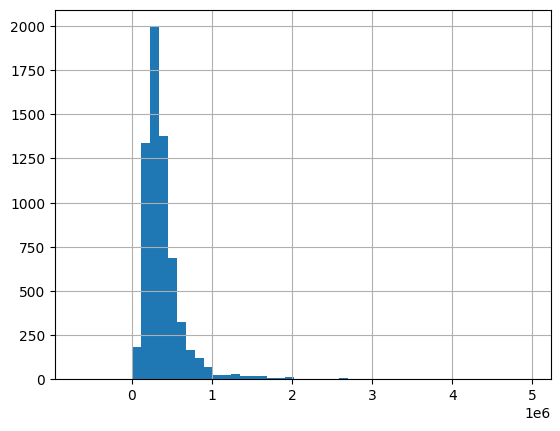

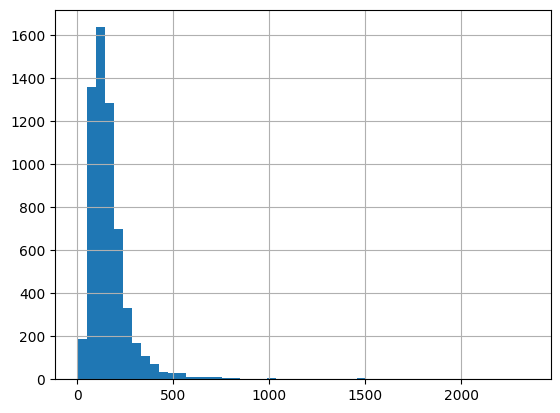

number_rooms
0.0      154500.0
1.0      205000.0
2.0      272850.0
3.0      349000.0
4.0      395000.0
5.0      469000.0
6.0      510000.0
7.0      550000.0
8.0      599000.0
9.0      992499.5
10.0     677000.0
11.0     325000.0
12.0    1172500.0
14.0    1995000.0
15.0    1175000.0
16.0     690000.0
17.0     750000.0
18.0    1575000.0
20.0     549000.0
23.0    1750000.0
24.0    4950000.0
29.0     990000.0
50.0    1999000.0
Name: price, dtype: float64

In [71]:
#price outliers
df["price"].hist(bins=50)
plt.show()


#living_area outliers
df["living_area"].hist(bins=50)
plt.show()

#correlation
df.corr(numeric_only=True)["price"].sort_values(ascending=False)   # correlation of Price

df.groupby("number_rooms")["price"].median()

